In [18]:
from tensorflow import keras

In [3]:
!pip install gdown

  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
Using cached filelock-3.13.1-py3-none-any.whl (11 kB)
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)


In [2]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
From (redirected): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd&confirm=t&uuid=72af1458-987d-4f57-9e0e-84be22e96f82
To: c:\Users\SBA\my_ws\GoogleCloudAI\edu\deep_learning\dogs-vs-cats.zip
100%|██████████| 852M/852M [00:15<00:00, 56.2MB/s] 


'dogs-vs-cats.zip'

In [5]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

'unzip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'unzip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [29]:
train_cnt = 5000
valid_cnt = 2500
test_cnt  = 5000
valid_end = train_cnt+valid_cnt
test_end = valid_end + test_cnt

In [30]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=train_cnt)
make_subset("validation", start_index=train_cnt, end_index=valid_end)
make_subset("test", start_index=valid_end, end_index=test_end)

## 특성 추출


![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)


ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다. 그런 다음 이 특성으로 강아지 vs. 고양이 분류기를 훈련합니다.

VGG16 모델은 케라스에 패키지로 포함되어 있습니다. `keras.applications` 모듈에서 임포트할 수 있습니다. `keras.applications` 모듈에서 사용 가능한 이미지 분류 모델은 다음과 같습니다(모두 ImageNet 데이터셋에서 훈련되었습니다):

* **Xception**
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

VGG16 모델을 만들어 보죠:

In [31]:
import os

# Hyper Parameter
IMG_SIZE = 150
IMG_CH = 3
BATCH_SIZE = 20

In [32]:
from tensorflow.keras.applications import Xception

# 사전학습된 모델에서 분류기(classifier를 포함해서 불러올지 결정-> include_top)
# include_top = True (포함)
conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_SIZE, IMG_SIZE, IMG_CH))


VGG16 함수에 세 개의 매개변수를 전달합니다:

* `weights`는 모델을 초기화할 가중치 체크포인트를 지정합니다.
* `include_top`은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 지정합니다. 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함합니다. 별도의 (강아지와 고양이 두 개의 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함시키지 않습니다.
* `input_shape`은 네트워크에 주입할 이미지 텐서의 크기입니다. 이 매개변수는 선택사항입니다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있습니다.

다음은 VGG16 합성곱 기반층의 자세한 구조입니다. 이 구조는 앞에서 보았던 간단한 컨브넷과 비슷합니다.

In [33]:

conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

최종 특성 맵의 크기는 `(4, 4, 512)`입니다. 이 특성 위에 완전 연결 층을 놓을 것입니다.
이 지점에서 두 가지 방식이 가능합니다.

* 새로운 데이터셋에서 합성곱 기반층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그다음 이 데이터를 이 책의 1부에서 보았던 것과 비슷한 독립된 완전 연결 분류기에 입력으로 사용합니다. 합성곱 연산은 전체 과정 중에서 가장 비싼 부분입니다. 이 방식은 모든 입력 이미지에 대해 합성곱 기반층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듭니다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없습니다.
* 준비한 모델(`conv_base`) 위에 `Dense` 층을 쌓아 확장합니다. 그다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 듭니다.

두 가지 방식을 모두 다루어 보겠습니다. 첫 번째 방식을 구현하는 코드를 살펴봅니다. `conv_base`에 데이터를 주입하고 출력을 기록합니다. 이 출력을 새로운 모델의 입력으로 사용하겠습니다.

먼저 앞서 소개한 `ImageDataGenerator`를 사용해 이미지와 레이블을 넘파이 배열로 추출하겠습니다. `conv_base` 모델의 `predict` 메서드를 호출하여 이 이미지에서 특성을 추출합니다.

In [34]:
import os, shutil

# 소규모 데이터셋을 저장할 디렉터리
base_dir = 'C:/Users/SBA/my_ws/GoogleCloudAI/edu/deep_learning/cats_vs_dogs_small'

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cat')

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dog')

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cat')

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dog')

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cat')

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dog')

In [35]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 5000
훈련용 강아지 이미지 전체 개수: 5000
검증용 고양이 이미지 전체 개수: 2500
검증용 강아지 이미지 전체 개수: 2500
테스트용 고양이 이미지 전체 개수: 5000
테스트용 강아지 이미지 전체 개수: 5000


In [36]:
trainIMG_NUM = len(os.listdir(train_cats_dir))+len(os.listdir(train_dogs_dir))
validIMG_NUM = len(os.listdir(validation_cats_dir))+len(os.listdir(validation_dogs_dir))

In [37]:
n_classes=2

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
# CNN = Feature Extractor + Classifier
model = models.Sequential()
# Feature Extractor(conv_base)
model.add(conv_base)

# New Classifier
#model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(1, activation='sigmoid'))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

이 모델의 구조는 다음과 같습니다:

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


여기서 볼 수 있듯이 VGG16의 합성곱 기반층은 14,714,688개의 매우 많은 파라미터를 가지고 있습니다. 합성곱 기반층 위에 추가한 분류기는 2백만 개의 파라미터를 가집니다.

모델을 컴파일하고 훈련하기 전에 합성곱 기반층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다. 맨 위의 `Dense` 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것입니다. 이는 사전에 학습된 표현을 크게 훼손하게 됩니다.

케라스에서는 `trainable` 속성을 `False`로 설정하여 네트워크를 동결할 수 있습니다:

In [23]:
model.trainable_weights

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 4.01871502e-01,  6.77069500e-02, -9.92160812e-02,
           -2.40881741e-01,  4.94409263e-01, -1.35092044e+00,
           -7.53455386e-02, -1.15802072e-01,  2.54089713e-01,
            4.12381589e-01, -2.02945337e-01, -5.65736771e-01,
            1.53094187e-01, -5.43646663e-02,  9.78396833e-02,
           -2.72699267e-01, -9.39905122e-02,  3.93782228e-01,
            3.33525687e-01,  2.95914084e-01, -3.14331800e-02,
           -1.99261308e-01,  1.59772888e-01, -3.25841278e-01,
           -1.50597319e-01, -7.27500841e-02,  1.80662051e-02,
            3.05232316e-01,  8.96351188e-02,  2.89342284e-01,
           -2.50950217e-01, -7.65512884e-01],
          [ 4.84812856e-02,  4.23621461e-02,  4.00314759e-03,
           -3.78118306e-02, -5.52299500e-01,  7.35755444e-01,
           -3.38940531e-01, -1.09324297e-02, -8.63540769e-02,
           -7.23446161e-02, -5.50143421e-01, -5.00105917e-01,
      

In [39]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:',
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 156


In [13]:
conv_base.trainable = False

In [40]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:',
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 156


이렇게 설정하면 추가한 두 개의 `Dense` 층의 가중치만 훈련될 것입니다. 층마다 두 개씩(가중치 행렬과 편향 벡터) 총 네 개의 텐서가 훈련됩니다. 변경 사항을 적용하려면 먼저 모델을 컴파일해야 합니다. 컴파일 단계 후에 `trainable` 속성을 변경하면 반드시 모델을 다시 컴파일해야 합니다. 그렇지 않으면 변경 사항이 적용되지 않습니다.

이제 앞의 예제에서 사용했던 데이터 증식을 사용하여 모델 훈련을 시작할 수 있습니다:

In [29]:
!pip install pillow
!pip install scipy

  Using cached Pillow-10.1.0-cp39-cp39-win_amd64.whl.metadata (9.6 kB)
Using cached Pillow-10.1.0-cp39-cp39-win_amd64.whl (2.6 MB)


In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data augmentation은 train 데이터에만 적용해야 한다!!!
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# binary-classfication에서는 binary_crossentropy
# multi-classification에서는 categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

#150x150에서 가장 높은 val_acc=> 0.914
history = model.fit(
      train_generator,
      steps_per_epoch = trainIMG_NUM/BATCH_SIZE, #2000 -> Train(cats+dogs) 이미지의 갯수
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validIMG_NUM/BATCH_SIZE)

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/30
500/500 [==============================] - 85s 161ms/step - loss: 0.2752 - acc: 0.8820 - val_loss: 0.0848 - val_acc: 0.9680
Epoch 2/30
500/500 [==============================] - 81s 163ms/step - loss: 0.1293 - acc: 0.9490 - val_loss: 0.0698 - val_acc: 0.9740
Epoch 3/30
500/500 [==============================] - 82s 164ms/step - loss: 0.0943 - acc: 0.9647 - val_loss: 0.0608 - val_acc: 0.9762
Epoch 4/30
500/500 [==============================] - 82s 164ms/step - loss: 0.0725 - acc: 0.9730 - val_loss: 0.0567 - val_acc: 0.9790
Epoch 5/30
500/500 [==============================] - 85s 170ms/step - loss: 0.0603 - acc: 0.9781 - val_loss: 0.0575 - val_acc: 0.9800
Epoch 6/30
500/500 [==============================] - 85s 169ms/step - loss: 0.0472 - acc: 0.9828 - val_loss: 0.0522 - val_acc: 0.9810
Epoch 7/30
500/500 [==============================] - 85s 169ms/step - loss: 0.0452 - acc: 0.9843 - val_l

In [16]:
!nvidia-smi

Mon Nov 13 11:37:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.49       Driver Version: 528.49       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 28%   55C    P8    18W / 125W |   5401MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 10000 images belonging to 2 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
model.save('C:/Users/SBA/my_ws/GoogleCloudAI/edu/deep_learning/data/cats_and_dogs_small_3.h5')

결과 그래프를 다시 그려 봅시다:

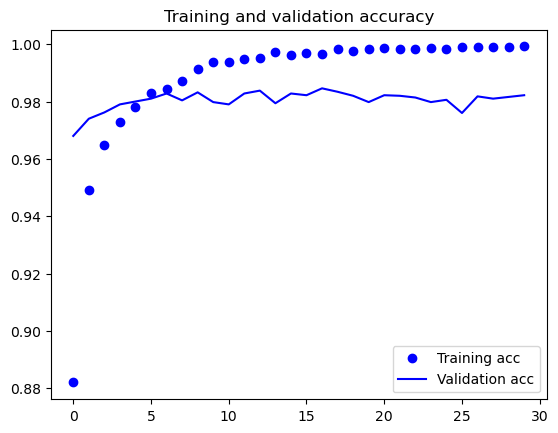

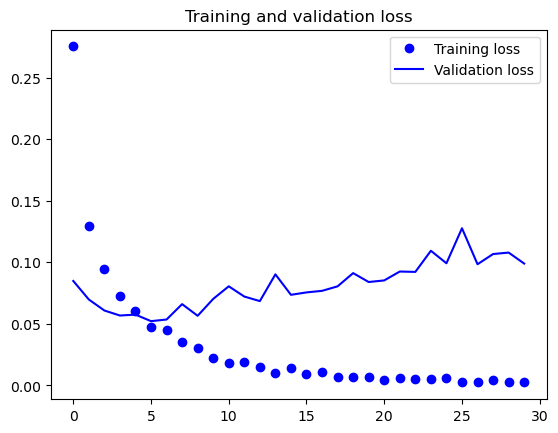

In [48]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
test_loss, test_acc = model.evaluate(test_generator)

500/500 [==============================] - 18s 35ms/step - loss: 0.1170 - acc: 0.9802
